## LASSO Regression Model for a Bike Sharing Dataset

This dataset has bike rentals in 2011 and 2012 from Capital bikeshare. The dataset is described here:
http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset	

and is available (day.csv) for download from:
http://archive.ics.uci.edu/ml/machine-learning-databases/00275/

Author: John Saja


In [1]:
# set up the pyspark environment
import os
import sys

spark_path = "C:\spark\spark-2.1.0-bin-hadoop2.7"

os.environ['SPARK_HOME'] = spark_path
os.environ['HADOOP_HOME'] = spark_path

sys.path.append(spark_path + "/bin")
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/pyspark/")
sys.path.append(spark_path + "/python/lib")
sys.path.append(spark_path + "/python/lib/pyspark.zip")
sys.path.append(spark_path + "/python/lib/py4j-0.10.4-src.zip")

import pyspark
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import SQLContext

# Stop Spark context started by default and start another Spark context
# Allows code to reexecute without error
sc = SparkContext("local", "test")

spark = SparkSession(sc)

import pyspark.sql
from pyspark.sql.functions import col, avg

# Profile data

Read the bike share dataset into a Pyspark data frame.

In [2]:
path = "C:/Users/John/Desktop/INET 4061/Labs/Lab3/Bike-Sharing-Dataset/"
file = "day.csv"
df = spark.read.csv( ''.join([path, file]) ,header = True, inferSchema = True)
# Cache the dataset in memory the first time it is used
# Reread the dataset from memory instead of rereading from disk
df.cache()
df.printSchema()

root
 |-- instant: integer (nullable = true)
 |-- dteday: timestamp (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)



In [3]:
print ("Dataset has %d rows." % df.count())

Dataset has 731 rows.


In [4]:
df = df.drop("dteday").drop("atemp")
df.take(3)

[Row(instant=1, season=1, yr=0, mnth=1, holiday=0, weekday=6, workingday=0, weathersit=2, temp=0.344167, hum=0.805833, windspeed=0.160446, casual=331, registered=654, cnt=985),
 Row(instant=2, season=1, yr=0, mnth=1, holiday=0, weekday=0, workingday=0, weathersit=2, temp=0.363478, hum=0.696087, windspeed=0.248539, casual=131, registered=670, cnt=801),
 Row(instant=3, season=1, yr=0, mnth=1, holiday=0, weekday=1, workingday=1, weathersit=1, temp=0.196364, hum=0.437273, windspeed=0.248309, casual=120, registered=1229, cnt=1349)]

In [5]:
df_var = df.select('workingday','casual','windspeed','hum','temp')
df_var.describe(['casual','windspeed','hum','temp']).show()

+-------+-----------------+-------------------+------------------+-------------------+
|summary|           casual|          windspeed|               hum|               temp|
+-------+-----------------+-------------------+------------------+-------------------+
|  count|              731|                731|               731|                731|
|   mean|848.1764705882352| 0.1904862116279068|0.6278940629274962|0.49538478850889184|
| stddev|686.6224882846551|0.07749787068166944| 0.142429095138354|0.18305099611148876|
|    min|                2|          0.0223917|               0.0|          0.0591304|
|    max|             3410|           0.507463|            0.9725|           0.861667|
+-------+-----------------+-------------------+------------------+-------------------+



In [6]:
# randomly select train (70%) and test (30%) datasets
train, test = df_var.randomSplit([0.7, 0.3])
type(train)

pyspark.sql.dataframe.DataFrame

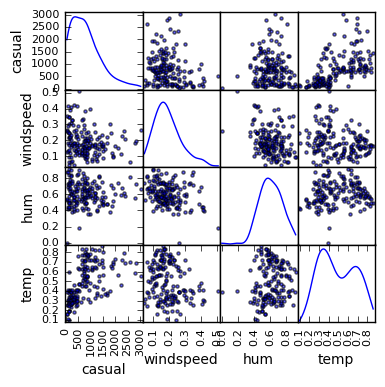

In [7]:
import numpy as np
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt

# sample 30% of the training observations without replacement for plotting purposes
sample_train = train.sample(False, 0.3)

# kde = kernel density estimate
pdf_sample = sample_train.select('casual','windspeed','hum','temp').toPandas()
fig = scatter_matrix(pdf_sample, alpha=0.6, figsize=(4, 4), diagonal='kde')
plt.show()

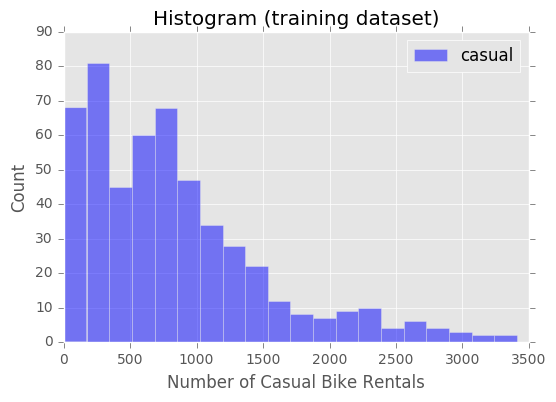

In [8]:
import matplotlib
matplotlib.style.use('ggplot')

h = train.select('casual').toPandas()
h.plot.hist(alpha=0.5, facecolor='blue', bins=20)
plt.xlabel('Number of Casual Bike Rentals')
plt.ylabel('Count')
plt.title('Histogram (training dataset)')
plt.show()

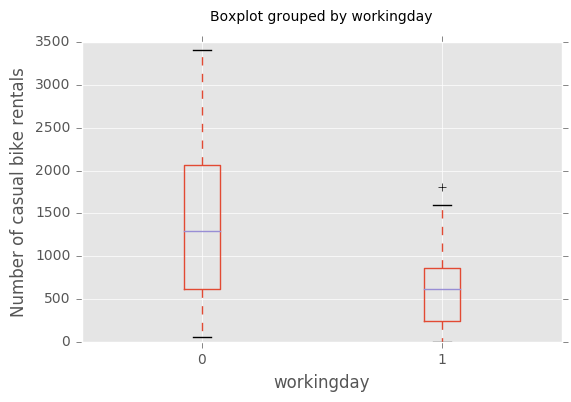

In [9]:
b = train.select('workingday', 'casual').toPandas()
bp = b.boxplot(column='casual', by='workingday', return_type='axes')
plt.ylabel('Number of casual bike rentals')
plt.title('')
plt.show()

## LASSO Regression Model

What is LASSO, and why do we use it?

LASSO is an acronym for **L**east **A**bsolute **S**hrinkage & **S**election **O**perator.

Historically, Ordinary Least Squares is a technique used for elementary regression methods, most notably linear regression.
However, when working with high dimensional data, regression computation can become very expensive. 

The objective of Lasso is to determine optimal coefficients through the process of penalizing them. An advantage of this is that it can penalize coefficients to 0, relaxing computation for high dimensional data and increasing interpretability and prediction accuracy.

At this point, it might be confusing what is meant by penalization. First off, it might help to ask the question of *why* we want to penalize the magnitude of coefficients. We do this becaude as our model increases in complexity through the addition of new variables, the size of our coefficients tends to increase dramatically. However, this generates misleading results because large magnitudes of coefficients imply that the variable is useful in the model. Thus, we might end up with a variable that's *telling* us it's useful when in reality it's not. The implication of this is that this an lead to overfitting of the training data.

Now that the concept of penalization is a bit more clear, how is it incorporated into the LASSO model?

Penalization in the LASSO model is known as an L1 absolute Value penalty term. Lets first look at the model in laymans terms to make sense of it

$Mininmization\ Objective = RSS + 	α(Sum\ of\ absolute\ values\ of\ coefficients)$

The righthand term is what the L1 penalty is. Alpha is a value known as the shrinkage factor. The minimization objective comes with the tradeoff of a bigger RSS for a lower penalty term and vice-versa. We can see the interaction between values of alpha and the values of penalized coefficients by the following:

$α = 0$ : Same coefficients as linear regression.

$α = \infty$ : All coefficients are 0.

$0 < α < \infty$ : Coefficients between linear regression and 0.

As an aside, it might also be useful to note that common statistics such as p-values and confidence intervals don't exist for this model.


Due to it's similarity to the linear model, it takes the same set of assumptions of that model:
* Linear Relationship betweeen independent & dependent variables.
* Little / No collinearity
* Multivariate Normality
* Homoscedasticity

These are very important to note as failing any of these is highly indicitive that any results produced from the model are either misleading or incorrect. From the plots above, we can visually verify that the first assumption is likely violated - So it would be a good idea to take our results below with a grain of salt.


### In the code below, we will explore how training a LASSO model with different values of alpha affect model performance.

## 1) Import dependencies

In [10]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn
from sklearn import datasets, linear_model
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
type(df)

pyspark.sql.dataframe.DataFrame

## 2) Train & capture data for 750 LASSO models with different alpha values (0-75)

In [11]:
df_train   = train.select('casual','windspeed','hum','temp')
df_train_x = df_train.select('windspeed','hum','temp')
pd_train_x = df_train_x.toPandas()             # pandas.core.frame.DataFrame
pf_train_y = df_train.select('casual').toPandas()
series_y   = pf_train_y["casual"]


df_test_x = test.select('windspeed','hum','temp')
pd_test_x = df_test_x.toPandas()             # pandas.core.frame.DataFrame
pf_test_y = test.select('casual').toPandas()
test_y = pf_test_y["casual"]

# pd_train_x.shape      # (493, 3)
# df_train_y.shape      # (493, 1)
alpha = 0.1
alpha_arr = np.array(np.arange(0,75,0.1))

#initialize various parameter lists to be converted to numpy arrays
wind = []
hum = []
temp = []
MSE = []
R2 = []
var = []


#model for different values of alpha
for x in range(0, 750):
    x = x/10
    #Run the linear model for a given alpha
    lm = linear_model.Lasso(alpha = x)
    lm.fit(pd_train_x, series_y)
    wind.append(lm.coef_[0]/1000)
    hum.append(lm.coef_[1]/1000)
    temp.append(lm.coef_[2]/1000)
    MSE.append(np.mean((lm.predict(pd_train_x) - series_y) ** 2))
    R2.append(r2_score(test_y, lm.predict(pd_test_x)))
    var.append(lm.score(pd_train_x, series_y))

#convert all lists to numpy arrays for visualization
wind_arr = np.array(wind)
hum_arr = np.array(hum)
temp_arr = np.array(temp)
MSE_arr = np.array(MSE)
R2_arr = np.array(R2)
var_arr = np.array(var)

C:\Users\John\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
C:\Users\John\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
C:\Users\John\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


## 3) Results: Scaled Coefficient Values vs. Alphas

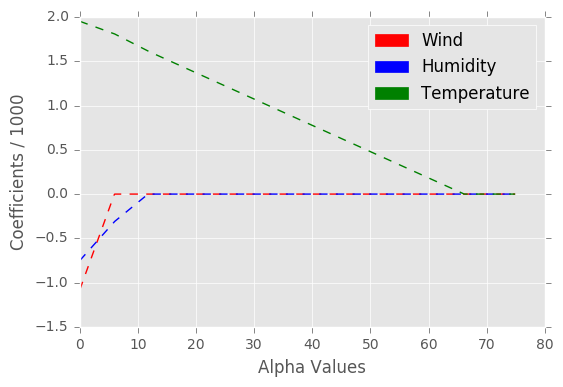

In [12]:
plt.xlabel('Alpha Values')
plt.ylabel('Coefficients / 1000')
plt.plot(alpha_arr, wind_arr, 'r--', alpha_arr, hum_arr, 'b--', alpha_arr, temp_arr, 'g--')

#Label lines
red_patch = mpatches.Patch(color='red', label='Wind')
blue_patch = mpatches.Patch(color='blue', label='Humidity')
green_patch = mpatches.Patch(color='green', label='Temperature')
plt.legend(handles=[red_patch, blue_patch, green_patch])

plt.show()

## 3) Results: Mean Squared Error (MSE) vs. Alphas

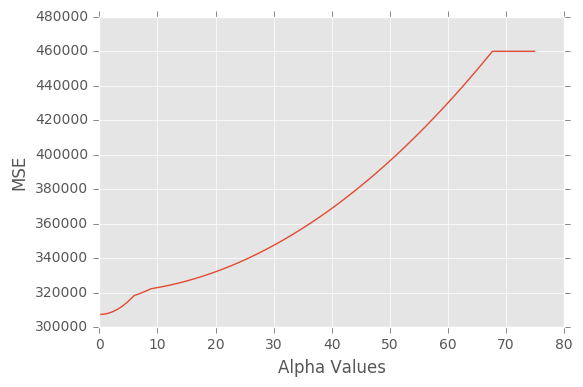

In [21]:
plt.xlabel('Alpha Values')
plt.ylabel('MSE')
plt.plot(alpha_arr, MSE_arr)
plt.show()

## 3) Results: R-Squared vs. Alphas

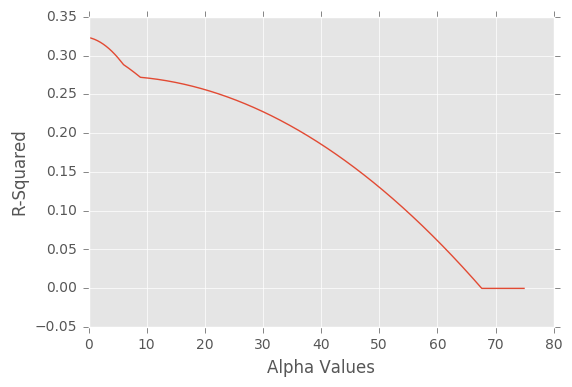

In [22]:
plt.xlabel('Alpha Values')
plt.ylabel('R-Squared')
plt.plot(alpha_arr, R2_arr)
plt.show()

## 3) Results: Variance Score vs. Alphas

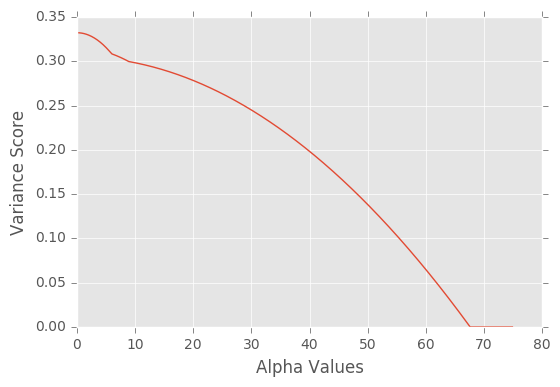

In [23]:
#Variance score vs. Alphas
plt.xlabel('Alpha Values')
plt.ylabel('Variance Score')
plt.plot(alpha_arr, var_arr)
plt.show()

## 3) Results: predicted vs. actual y-values  for linear regression & benchmark alpha values

C:\Users\John\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  app.launch_new_instance()
C:\Users\John\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)


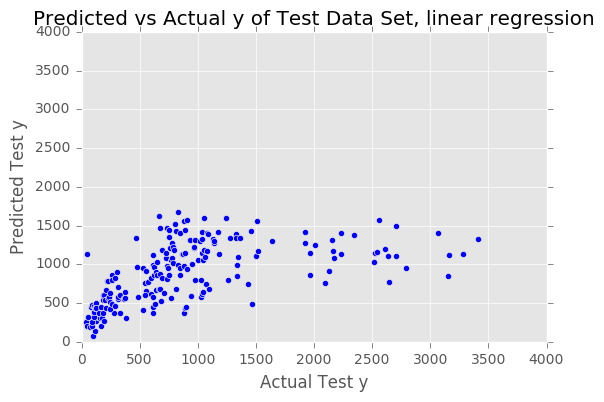

MSE:  288199.49546
R-Squared:  0.313577547966
Variance Score 0.336157881353


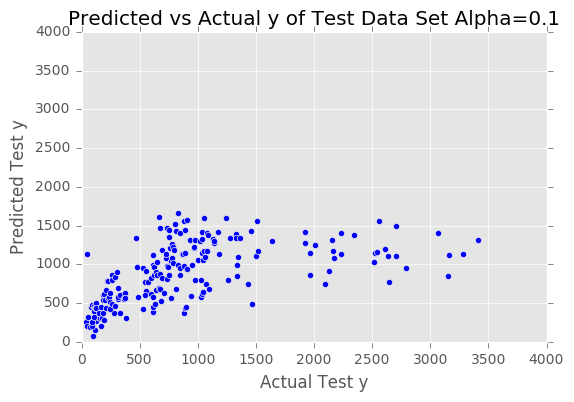

MSE:  288202.434077
R-Squared:  0.313535518956
Variance Score 0.336151112508


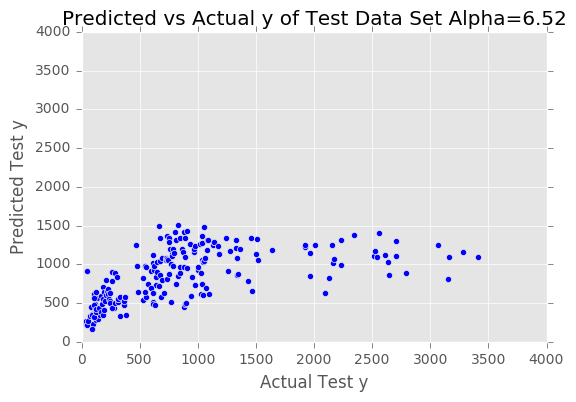

MSE:  298685.406236
R-Squared:  0.293513378002
Variance Score 0.312004510735


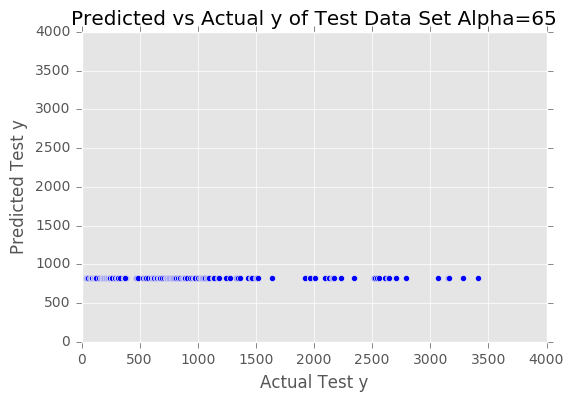

MSE:  434138.611222
R-Squared:  -0.0123835092274
Variance Score 0.0


In [31]:
#Linear regression
lm = linear_model.Lasso(alpha = 0)
lm.fit(pd_train_x, series_y)
pred_test = lm.predict(pd_test_x)

plt.axis([0,4000, 0, 4000])
plt.scatter(test_y, pred_test)
plt.title("Predicted vs Actual y of Test Data Set, linear regression")
plt.ylabel("Predicted Test y")
plt.xlabel("Actual Test y")
plt.show()
print('MSE: ', MSE_arr[0])
print('R-Squared: ', R2_arr[0])
print('Variance Score', var_arr[0])

#LASSO Alpha = 0.1
lm = linear_model.Lasso(alpha = 0.1)
lm.fit(pd_train_x, series_y)
pred_test = lm.predict(pd_test_x)

plt.axis([0,4000, 0, 4000])
plt.scatter(test_y, pred_test)
plt.title("Predicted vs Actual y of Test Data Set Alpha=0.1")
plt.ylabel("Predicted Test y")
plt.xlabel("Actual Test y")
plt.show()
print('MSE: ', MSE_arr[1])
print('R-Squared: ', R2_arr[1])
print('Variance Score', var_arr[1])

#Where wind coefficient becomes 0
lm = linear_model.Lasso(alpha = 6.5)
lm.fit(pd_train_x, series_y)
pred_test = lm.predict(pd_test_x)


plt.axis([0,4000, 0, 4000])
plt.scatter(test_y, pred_test)
plt.title("Predicted vs Actual y of Test Data Set Alpha=6.52")
plt.ylabel("Predicted Test y")
plt.xlabel("Actual Test y")
plt.show()
print('MSE: ', MSE_arr[65])
print('R-Squared: ', R2_arr[65])
print('Variance Score', var_arr[65])

#all coefficients 0
lm = linear_model.Lasso(alpha = 65)
lm.fit(pd_train_x, series_y)
pred_test = lm.predict(pd_test_x)
plt.axis([0,4000, 0, 4000])
plt.scatter(test_y, pred_test)
plt.title("Predicted vs Actual y of Test Data Set Alpha=65")
plt.ylabel("Predicted Test y")
plt.xlabel("Actual Test y")
plt.show()
print('MSE: ', MSE_arr[650])
print('R-Squared: ', R2_arr[650])
print('Variance Score', var_arr[650])

## Model output overview:

In the performance of the model, we can look at various statistics in helping us understand how well lasso performed for different alpha values. This includes the Variance Score, R- Squared Value, and Mean-squared error. From looking at these statistics from all of the graphs above, we could possibly conclude that the LASSO model is outperformed by the simple linear regression model for the Bike-Sharing dataset

This is due to the following trends. **As alpha increases**:

* **Variance Score decreases**, so our predictive power worsens.
* **R-Squared decreases**, so less variance is explained by the penalized coefficients.
* **Mean-Squared Error increases**, so the distance between the predicted and actual values increases.

In [ ]:
sc.stop()